# Bandits with unobserved confounders: A causal Approach


# Outline

- **The multi-armed bandit problem**

- **The Greedy casino problem**

- **The drunk gambler**

- **Random sampling**

- **Thompson sampling**

- **Causal Thompson sampling**

- **Results**  

- **Policy evaluation using Counterfactual Reasoning** 

- **Key learnings**



## The multi-armed bandit problem

- Consider n-slot machines $S_1,\ S_2,\ S_3\ ...\ S_n$. Given that the payouts of each slot machine is unknown, the goal is to come up with a sequence of actions that would maximize the reward.

- The multi-armed bandit problem revolves around developing a strategy in learning the true payout distributions of each of these slot machines.

# The Greedy casino problem

Consider this scenario, a greedy casino owner observes gamblers and their behavior so as to maximize the profits of the casino.

On observation, the casino owner learns that the choice of pulling an arm (of the slot machine) is influenced by 2 factors

- The gamber being drunk

- The machine blinking

**Suppose also that a new gambling law requires that casinos maintain a minimum attainable payout rate for slots of 30%. Cognizant of this new law, while still wanting to maximize profits by exploiting gamblers’ natural arm choices,
the casino executives modify their new slots with the payout rates depicted in this table**

<table>
    <tr>
        <th>(a)</th>
        <th colspan="2">D=0</th>
        <th colspan="2">D=1</th>
    </tr>
    <tr>
        <th></th>
        <th>B=0</th>
        <th>B=1</th>
        <th>B=0</th>
        <th>B=1</th>
    </tr>
    <tr>
        <td>X=M1</td>
        <td>0.1*</td>
        <td>0.5</td>
        <td>0.4</td>
        <td>0.2*</td>
    </tr>
    <tr>
        <td>X=M2</td>
        <td>0.5</td>
        <td>0.1*</td>
        <td>0.2*</td>
        <td>0.4</td>
    </tr>
</table>

$D=1$: gambler is drunk $P(D=1) = 0.5$

$B=1$: blinking machine $P(B=1) = 0.5$

$X = d \oplus b$: choice of arm

\* indicates the user preference. It can be seen that the gambler has a very low chance of winning given these preferences.

The DAG of the model would look something like this

![Model DAG](https://i.imgur.com/PuTvSej.png)

In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 430kB 4.6MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
from pyro import sample, condition, do, infer
import pyro.distributions as dist
from torch import tensor
from pyro.poutine import trace
from csv import writer
import pandas as pd
from numpy import ones
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class Game(object):
    """
    Simulation of the game
    drunk_pr: probability of a gambler being drunk
    blink_pr: probability that machine would be blinking
    payout_pr: probability of payout
    policy: an object of the Policy class containing two methods choose_arm() and update(Y)
    T: number of trials
    """
    def __init__(self, drunk_pr, blink_pr, payout_pr, policy=None, T=1000):
        self.drunk_pr = drunk_pr
        self.blink_pr = blink_pr
        self.payout_pr = payout_pr
        self.policy = policy
        self.T = T
        self.chosen_arm = 0
        
        # Save the arms chosen and rewards  
        self.logs = []
        
        # information about drunk and blinking
        self.config = [0.] * len(self.payout_pr[0])
        self.current_config = -1
        
        # cumulative regret 
        self.cumulative_regret = []
        
        # Choosing the best arm 
        self.best_arm_prob = []
        self.best_arm_count = 0
    
    
    def fb(self):
        return sample("b", dist.Bernoulli(self.blink_pr))
    
    def fd(self):
        return sample("d", dist.Bernoulli(self.drunk_pr))

    def fx(self,b, d):
        return sample("x", dist.Delta(tensor(float(int(b) ^ int(d))))) 

    def fy(self,x, b, d):
        return sample("y", dist.Bernoulli(self.payout_pr[int(x)][int(b + 2*d)]))

    def model(self):
        b = self.fb()
        d = self.fd()
        x = self.fx(b, d)
        y = self.fy(x, b, d)
        return y
    
    # helper function to export the logs for future use
    def export(self, file="logs.csv"):
        with open(file,'w', newline='') as out:
            csv_out=writer(out)
            csv_out.writerow(['x', 'y'])
            for row in self.logs:
                csv_out.writerow(row)
    
    def play(self):
        for _ in range(self.T):
            if self.policy == None:
                trace_handler = trace(self.model)
                tr = trace_handler.get_trace()
                self.current_config = int(tr.nodes["b"]["value"].item() + 2 * tr.nodes["d"]["value"].item()) 
                self.config[self.current_config] += 1
                rec = (tr.nodes["x"]["value"].item(), tr.nodes["y"]["value"].item())
                self.logs.append(rec)
            else:
                # Generate the context/environment
                context = {}
                context["b"] = self.fb()
                context["d"] = self.fd()
                self.current_config = int(context["b"] + 2 * context["d"])
                self.config[self.current_config] += 1 
                
                # Use the appropriat policy to choose which arm needs to played next
                self.chosen_arm = self.policy.choose_arm(context)
                
                # intervene and pull
                int_model = do(condition(self.model, {"b": context["b"], "d": context["d"]}), {'x': self.chosen_arm})
                
                # get trace
                trace_handler = trace(int_model)
                tr = trace_handler.get_trace()
                rec = (self.chosen_arm.item(), tr.nodes["y"]["value"].item())
                
                # save arm and payout for the trial 
                self.logs.append(rec)
                
                # update policy
                self.policy.update(tr.nodes["y"]["value"])
                
            # update stats
            self.cumulative_regret.append(self.regret())
            self.best_arm_prob.append(self.best_arm())
    
    def regret(self):
        reward_sum = sum([el[1] for el in self.logs])
        return sum(self.payout_pr.max(dim=0)[0] * tensor(self.config)) - reward_sum
    
    def best_arm(self):
        # get the best arm for the current context
        best_val = np.argmax(self.payout_pr, axis=0)[self.current_config]
        self.best_arm_count += int(best_val == self.chosen_arm)
        return self.best_arm_count/len(self.logs)
      
    
    def stats(self):
        X_Y = []
        for k in [0.0, 1.0]:
            X_Y.append(len([self.logs[i][1] for i in range(len(self.logs)) if (self.logs[i][1] == 1.0  and self.logs[i][0] == k)])\
                        /len([el[0] for el in self.logs if el[0] == k]))

        stats = [X_Y[0],X_Y[1]]


        return stats

# Drunk Gambler  
The gamblers play according to their natural predilections

In [0]:
drunk_pr = tensor(0.5)
blink_pr = tensor(0.5)
payout_pr = tensor([[0.1, 0.5, 0.4, 0.2],
                    [0.5, 0.1, 0.2, 0.4]])
trials = 1000
N = 100 # Monte Carlo simulations
n_bandits = 2

In [0]:
drunk_regret = tensor([0.] * trials)
drunk_results = tensor([0.] * n_bandits)
for _ in range(N):
    game = Game(drunk_pr=drunk_pr, blink_pr=blink_pr, payout_pr=payout_pr, T=trials, policy=None)
    game.play()
    drunk_regret += tensor(game.cumulative_regret)
    drunk_results += tensor(game.stats())

On running a simulation of the drunk gambler playing based on this new set up, we would get the following results

In [5]:
pd.DataFrame((drunk_results/N).tolist(), columns=["P(Y=1|X)"], index=["X=M1","X=M2"])

,P(Y=1|X)
X=M1,0.150353
X=M2,0.150313


# Gaming Commission  
The state decides to test if the 30% payout criterion is satisfied at this casino. This is done by choosing an arm based on a coin-flip i.e. $P(X=M_1) = P(X=M_2) = 0.5$

In [0]:
class Policy(object):
    def __init__(self):
        pass
    def update(self, Y):
        pass
    def choose_arm(self, context=None):
        pass

In [0]:
class RandomSampler(Policy):
    """
    Implementation of a Random Sampler where choosing each arm has equal probability
    n_bandits: Number of slot machines
  """
    def __init__(self, n_bandits):
        self.n_bandits = n_bandits
        self.params = [{"w": 0, "l": 0} for _ in range(self.n_bandits)]
        self.arm_selected = 0
        
    def update(self, Y):
        if Y == 1:
            self.params[self.arm_selected]["w"] += 1
        else:
            self.params[self.arm_selected]["l"] += 1
            
    def choose_arm(self, context=None):
        # each arm has an equal chance of being selected
        probs = [1/self.n_bandits] * self.n_bandits
        self.arm_selected = sample("arm_selected", dist.Categorical(tensor(probs)))
        return self.arm_selected

In [0]:
commission_regret = tensor([0.] * trials)
commission_best_arm = tensor([0.] * trials)
commission_results = tensor([0.] * n_bandits)
for _ in range(N):
    game = Game(drunk_pr=drunk_pr, blink_pr=blink_pr, payout_pr=payout_pr, T=trials, policy=RandomSampler(n_bandits=2))
    game.play()
    commission_regret += tensor(game.cumulative_regret)
    commission_best_arm += tensor(game.best_arm_prob)
    commission_results += tensor(game.stats())
    

On running a simulation of the gaming commission verifying the 30% payout, we would get the following results

In [9]:
pd.DataFrame((commission_results/N).tolist(), columns=["P(Y=1|X)"], index=["X=M1","X=M2"])

,P(Y=1|X)
X=M1,0.297600
X=M2,0.298539


It can be seen from the results that:
    
- The two arms are indistinguishable.

- A user choosing based on natural predilections has a lower chance of winning.

- The gaming commission conclude that the 30% criteria has been met.

# Thompson Sampling  
Thompson sampling is a very well known algorithm used widely in multi-class bandit problems.

In [0]:
class ThompsonSampler(Policy):
    """
    Implementation of Causal Thompson sampling 
    n_bandits: Number of slot machines
  """
    def __init__(self, n_bandits):
        self.n_bandits = n_bandits
        # keep track of rewards for each arm
        self.params = [{"a": 1, "b": 1} for _ in range(self.n_bandits)]
        self.arm_selected = 0
    
    def update(self, Y):
        # update parameters based on payout
        if Y == 1:
            self.params[self.arm_selected]["a"] += 1
        else:
            self.params[self.arm_selected]["b"] += 1
            
    def choose_arm(self, context=None):
        # determine weights based on past rewards
        probs = [el["a"]/(el["a"] + el["b"]) for el in self.params]
        
        # sample arm from a categorical distribution
        self.arm_selected = sample("arm_selected", dist.Categorical(tensor(probs)))
        return self.arm_selected

In [0]:
thompson_regret = tensor([0.] * trials)
thompson_best_arm = tensor([0.] * trials)
thompson_results = tensor([0.] * n_bandits)
for _ in range(N):
    game = Game(drunk_pr=drunk_pr, blink_pr=blink_pr, payout_pr=payout_pr, T=trials, policy=ThompsonSampler(n_bandits=2))
    game.play()
    thompson_regret += tensor(game.cumulative_regret)
    thompson_best_arm += tensor(game.best_arm_prob)
    thompson_results += tensor(game.stats())

In [12]:
pd.DataFrame((thompson_results/N).tolist(), columns=["P(Y=1|X)"], index=["X=M1","X=M2"])

,P(Y=1|X)
X=M1,0.301254
X=M2,0.299237


As we can see , Thompson sampling performs no better than a Random sampler

# Causal Thompson sampling  
This is a new sampling method developed to account for unobserved confounders while sampling. Thompson sampling does not perform particularly well when there are unobserved confounders.

## How Causal Thompson sampling works  
A causal thompson sampler takes into account the users intuition to play an arm and suggests an introspection comparing the odds of winning following his intuition or going against it. It considers using the rule that compares the average payouts obtained by players for choosing in favour or against their intuition. This procedure is called regret decision criteria. We exploit the fact that a superior arm will emerge quickly by weighting the favorable arm by making it more likely to be chosen early in the learning process.

In [0]:
class CausalThompsonSampler(Policy):
    """
        Implementation of Causal Thompson sampling 
        n_bandits: Number of slot machines
        payout_pr: Probability of payout
    """
    def __init__(self, n_bandits, payout_pr):
        self.n_bandits = n_bandits
        
        # success and failure counts of playing an arm (Observation)
        self.s = ones((2,2))
        self.f = ones((2,2))
      
        # arm selected based on the causal thompson policy
 
        self.arm_selected = 0
        
        # arm based on intuition
        self.x_intuition = 0
        
         # P(Y=1|X=0, Z=0) * 100 , Z is the intuition 
        self.s[0][0] = (payout_pr[0][0] + payout_pr[0][3]) * 100/2 
        
        # P(Y=1|X=1, Z=1) * 100 
        self.s[1][1] = (payout_pr[1][1] + payout_pr[1][2]) * 100/2
        
        # P(Y=0|X=0, Z=0) * 100 
        self.f[0][0] = (1 - payout_pr[0][0] + 1 - payout_pr[0][3]) * 100/ 2
        
        # P(Y=0|X=1, Z=1) * 100 
        self.f[1][1] = (1 - payout_pr[1][1] + 1 - payout_pr[1][2]) * 100/2   
       
        # P(Y=1|X) Probability of payout for each arm by observation 
        self.p_Y_X = [self.s[i][i]/(self.s[i][i] + self.f[i][i]) for i in range(self.n_bandits)]
        
        # updated probability of payout for each arm 
        self.theta = [0, 0]   
        
        
    def update(self, reward):
        # update the count of payouts
        self.s[self.x_intuition][self.arm_selected] += int(reward)
        self.f[self.x_intuition][self.arm_selected] += 1 - int(reward)   
  
    def choose_arm(self, context): 
        
        # arm to be played according to players natural predilection
        self.x_intuition = int(context['b']) ^ int(context['d'])
        
        # counter intuition, if x is 0, x' is 1 else 0
        x_prime = 1 - self.x_intuition
        
        # P(Y=1|do(X=x)) 
        p_Y_doX_Z = [[self.s[i][0]/(self.s[i][0] + self.f[i][0]), self.s[i][1]/(self.s[i][1] + self.f[i][1])] for i in range(self.n_bandits)] 

        # E(YX=x' |X = x) estimated payout for counter intuition
        Q1 = p_Y_doX_Z[self.x_intuition][x_prime]
        
        # P(y|X = x) , estimated payout for intuiton
        Q2 = self.p_Y_X[self.x_intuition] 
        
        # ETT
        bias = abs(Q1- Q2)
         
        # initialize weights
        w = ones(2)
        
        if np.isnan(bias):
            weight = 1
        else:
            weight = 1 - bias
        
        # choose arm to bias        
        if Q1 > Q2:
            w[self.x_intuition] = weight
        else:
            w[x_prime] = weight
        
        # choose arm
        self.theta = [sample("theta_0", dist.Beta(self.s[self.x_intuition][0], self.f[self.x_intuition][0])) * w[0],  sample("theta_1", dist.Beta(self.s[self.x_intuition][1], self.f[self.x_intuition][1])) * w[1]]
        self.arm_selected = self.theta.index(max(self.theta))
        return tensor(self.arm_selected)

In [0]:
causal_regret = tensor([0.] * trials)
causal_best_arm = tensor([0.] * trials)
causal_results = tensor([0.] * n_bandits)
for _ in range(N):
    game = Game(drunk_pr=drunk_pr, blink_pr=blink_pr, payout_pr=payout_pr, T=trials, policy=CausalThompsonSampler(n_bandits=2, payout_pr=payout_pr))
    game.play()
    causal_regret += tensor(game.cumulative_regret)
    causal_best_arm += tensor(game.best_arm_prob)
    causal_results += tensor(game.stats())

On running simulations of Causal Thompson sampling, we get the following results


In [15]:
pd.DataFrame((causal_results/N).tolist(), columns=["P(Y=1|X)"], index=["X=M1","X=M2"])

,P(Y=1|X)
X=M1,0.451602
X=M2,0.448715


# Results  

Cumulative regret for each policy

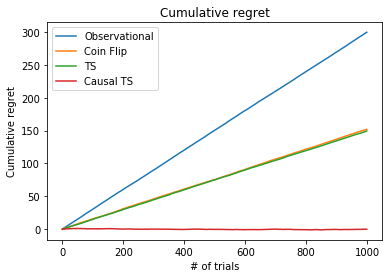

In [16]:
plt.figure()
plt.title("Cumulative regret")
plt.xlabel("# of trials")
plt.ylabel("Cumulative regret")
plt.plot([el.item() for el in list(drunk_regret/N)], label="Observational")
plt.plot([el.item() for el in list(commission_regret/N)], label="Coin Flip")
plt.plot([el.item() for el in list(thompson_regret/N)], label="TS")
plt.plot([el.item() for el in list(causal_regret/N)], label="Causal TS")
plt.legend()
plt.show()

Probability of choosing the best arm for each policy

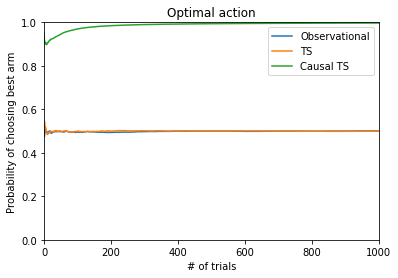

In [17]:
plt.figure()
plt.axis([0,1000, 0, 1.0])
plt.title("Optimal action")
plt.plot([el.item() for el in list(commission_best_arm/N)], label="Observational")
plt.plot([el.item() for el in list(thompson_best_arm/N)], label="TS")
plt.plot([el.item() for el in list(causal_best_arm/N)], label="Causal TS")
plt.xlabel("# of trials")
plt.ylabel("Probability of choosing best arm")
plt.legend()
plt.show()

# Policy Evaluation
Here we try to evaluate our causal thompson policy by using the logs from thompson sampling. 
This is a scenario of offline learning where we apply counterfactual reasoning to evaluate how the other policy would behave in the given environment.  
In order to do so, we infer the noise values (in our case the exogenous variables as we dont have any other noise) based on the X and Y (arm and reward)  
We use the Causal Thompson Policy to identify the arm that it would choose in the given environment.
We then condition the model on the noise variables and perform do operation on the model using the arm chosen by the Causal thompson policy.   
We perform this operation for every timestep in the logs. We compute the difference between the expected reward that we would have attained by using causal thompson policy vs the expected reward from using thompson policy . This is called as the counterfactual regret. 

## Collect logs from Thompson sampling

In [0]:
g = Game(0.5, 0.5, payout_pr, ThompsonSampler(n_bandits=2))
g.play()
g.export()

In [0]:
data = pd.DataFrame(g.logs, columns=['x', 'y'])

## Policy Evaluator

In [0]:
class PolicyEvaluator(object):
    """
        Implementation of Policy Evaluator 
        game: Game object that contains the model that was used to generate logs
        logs: data frame/file containing the logs for offline learning 
        policy: the policy that will be evaluated using the logs 
    """
    def __init__(self, game, logs, policy=None):
        self.game = game
        self.logs = logs
        self.rewards = []
        self.chosen_arms = []
        self.policy = policy
        self.cumulative_regret = []
        self.regular_regret = []
        self.best_arm_prob = []
        self.best_arm_count = 0
        self.game_config = [0.] * len(self.game.payout_pr[0])
        
        
        
    def __call__(self):
        # if we were to use the logs from a file
        # data = pd.read_csv(self.logs) 
        
        nrows = self.logs.shape[0]
        
        # for each timestep in the log data evaluate what Causal Thompson would do
        for i in range(nrows):
            rec = data.iloc[i, :] 
            
            # Logs consist of X and Y, we have to infer b and d from the model
            
            conditioned_model = condition(self.game.model, {"x": tensor(rec["x"]), "y": tensor(rec["y"])})
            posterior = infer.Importance(conditioned_model, num_samples=100).run()
            trace = posterior()
            b = trace.nodes["b"]["value"]
            d = trace.nodes["d"]["value"]
            
            context = {"b": b, "d": d}
            # the arm that the policy being evaluated would play in the given context
            chosen_arm = self.policy.choose_arm(context)
            
            # simulate outcome for the chosen arm
            model = do(condition(self.game.model, {"b": b, "d": d}), {"x": chosen_arm})
            y = model()
            
            # update policy
            self.policy.update(y)
            
            # save stats
            self.chosen_arms.append(int(chosen_arm))
            self.rewards.append(y)
            
            # estimate the probability of choosing best arm for the policy being evaluated
            self.game_config[int(2 * context['d'] + context['b'] )] += 1
            self.best_arm_prob.append(self.policy_best_arm(int(2 * context['d'] + context['b'] )))
            
            # estimate cumulative regret for the policy being evaluated
            self.regular_regret.append(self.policy_regret())
            
            # estimate counterfactual regret
            self.cumulative_regret.append(np.sum(self.rewards) - np.sum(self.logs['y'][:i])) 
    
    def policy_regret(self):
        return sum(self.game.payout_pr.max(dim=0)[0] * tensor(self.game_config)) - sum(self.rewards)
    
    def policy_best_arm(self, config):
        # get the best arm for the current context
        best_val = np.argmax(self.game.payout_pr, axis=0)[config]
        self.best_arm_count += int(best_val == self.chosen_arms[-1])
        return self.best_arm_count/len(self.rewards)
            
            
            
            
      

Evaluating the Causal Thompson Policy 

In [0]:
cf_regret = tensor([0.] * trials)
policy_regret = tensor([0.] * trials)
policy_best_arm = tensor([0.] * trials)
for _ in range(10):
    pe = PolicyEvaluator(g, data, policy=CausalThompsonSampler(n_bandits=2, payout_pr=payout_pr))
    pe()
    cf_regret += tensor(pe.cumulative_regret)
    policy_best_arm += tensor(pe.best_arm_prob)
    policy_regret += tensor(pe.regular_regret)
    
    

The payout rates for each arm when Causal Thompson sampling is used in the environment

In [22]:
pd.DataFrame(list(zip(pe.chosen_arms, [el.int().item() for el in pe.rewards])), columns=['X', 'P(Y=1|X)']).groupby(['X']).mean()

,P(Y=1|X)
X,
0,0.401302
1,0.473098


Total counterfactual regret - difference between expected rewards from thompson sampling vs causal thompson

In [23]:

np.sum(pe.rewards) - np.sum(data['y'])

149.0

## Cumulative Counterfactual Regret  

The increase in the cumulative counterfactual regret with the number of trials is expected as the causal thompson policy is able to identify the best arm and in turn increases the expected payout for using it vs standard thompson sampling

Text(0, 0.5, 'Cumulative regret')

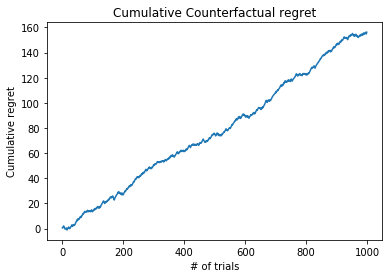

In [24]:
plt.title("Cumulative Counterfactual regret")
plt.plot([el.item() for el in list(cf_regret/10)])
plt.xlabel("# of trials")
plt.ylabel("Cumulative regret")

## Comparison of Cumulative regret for Causal Thompson Policy

The cumulative regret in the offline learning scenario is compared to the online learning setting.
In our case the regret is almost comparable.   
(The difference is due lesser number of MC simulations that were used for offline learning since inferring noise took a long time to run for each iteration)


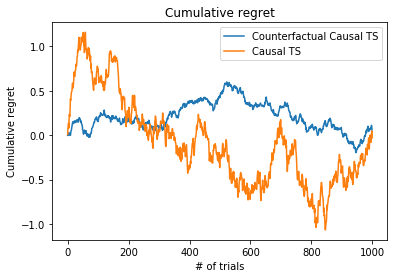

In [25]:
plt.figure()
plt.title("Cumulative regret")
plt.xlabel("# of trials")
plt.ylabel("Cumulative regret")
plt.plot([el.item() for el in list(policy_regret/N)], label="Counterfactual Causal TS")
plt.plot([el.item() for el in list(causal_regret/N)], label="Causal TS")
plt.legend()
plt.show()

## Comparison of Optimal action for Causal Thompson  Sampling  
The probability of choosing the best arm at each time step is compared for Causal Thompson sampling in the online and Offline scenarios.
As we can see even in the offline setting the policy is able to learn very quickly. 

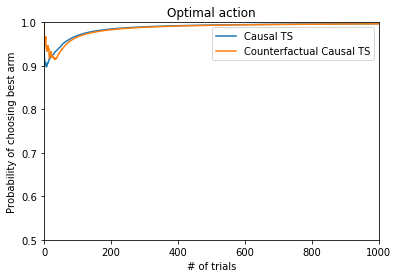

In [26]:
plt.figure()
plt.axis([0,1000, 0.5, 1.0])
plt.title("Optimal action")
plt.plot([el.item() for el in list(causal_best_arm/N)], label="Causal TS")
plt.plot([el.item() for el in list(policy_best_arm/10)], label = "Counterfactual Causal TS")
plt.xlabel("# of trials")
plt.ylabel("Probability of choosing best arm")
plt.legend()
plt.show()

# Key Learnings  
1) Understanding of multi-armed bandit problems

2) Understanding of Thompson sampling and its use in developing an optimal strategy

3) Effect of Thompson sampling in presence of unobserved confounders

4) Viewing the multi-armed bandit problem as a causal one

5) Performing counterfactual reasoning using Causal Thompson sampling 

6) Using counterfactual reasoning to perform Offline learning and evaluate the performance of Causal Thompson sampling over Thompson sampling 




# References
 [1]  [Bayesian methods for hackers , Cameron Davidson-Pilon](http://ptgmedia.pearsoncmg.com/images/9780133902839/samplepages/9780133902839.pdf)  
 [2]  https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master/Chapter6_Priorities  
 [3] [Causal Inference in Statistics  An Overview](https://ftp.cs.ucla.edu/pub/stat_ser/r350.pdf)  
 [4] [Bandits with Unobserved Confounders: A Causal Approach](https://papers.nips.cc/paper/5692-bandits-with-unobserved-confounders-a-causal-approach.pdf)  
 [5] https://github.com/ucla-csl/mabuc  
 [6] [Bandit Algorithms for Website Optimization](https://doc.lagout.org/science/0_Computer%20Science/2_Algorithms/Bandit%20Algorithms%20for%20Website%20Optimization%20%5BWhite%202013-01-03%5D.pdf)